In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from time import time
from keras.layers import Dense, Input,Conv1D, MaxPooling1D, Flatten, Embedding, Reshape, UpSampling1D
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import pickle

from scipy import special

Using TensorFlow backend.


In [2]:
P = np.array([
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
], dtype='int')

In [3]:
def custom_activation(x):
    return 1 / (1 + keras.backend.exp(-x))

In [4]:
def awgn(x_input, Es_No):
    sig_power = 1
    
    noise_power = np.sqrt(sig_power / (2 * Es_No))
    
    noise = noise_power * np.random.normal(size = x_input.shape)
    
    return x_input + noise

In [5]:
def absolute_mld(x_noisy):
    codeword = np.loadtxt('input.txt')
    codeword = np.where(codeword < 0, 1, 0)

    x_compare = np.where(x_noisy < 0.5, 1, 0)
#     x_compare = np.where(x_noisy < 0, 1, 0)
        
    for i in range(x_noisy.shape[0]):
        check = (x_compare[i,:] + codeword) % 2
        result = np.dot(np.abs(0.5-x_noisy[i, :]), check.T)
        index = result.argmin()
        
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return code

In [6]:
def square_mld(x_noisy):
    codeword = np.loadtxt('input.txt')
    codeword = np.where(codeword < 0, 1, 0)

#     x_compare = np.where(x_noisy < 0.5, 1, 0)
    x_compare = np.where(x_noisy < 0, 1, 0)
        
    for i in range(x_noisy.shape[0]):
        check = (x_compare[i,:] + codeword) % 2
#         result = np.dot(np.square(np.abs(0.5-x_noisy[i, :])), check.T)
        result = np.dot(np.square(np.abs(x_noisy[i, :])), check.T)
        index = result.argmin()
        
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return code

In [7]:
def square_3_mld(x_noisy):
    codeword = np.loadtxt('input.txt')
    codeword = np.where(codeword < 0, 1, 0)

    x_compare = np.where(x_noisy < 0.5, 1, 0)
#     x_compare = np.where(x_noisy < 0, 1, 0)
        
    for i in range(x_noisy.shape[0]):
        check = (x_compare[i,:] + codeword) % 2
        result = np.dot(np.abs(0.5-x_noisy[i, :])**4, check.T)
#         result = np.dot(np.abs(x_noisy[i, :])**4, check.T)
        index = result.argmin()
        
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return code

In [8]:
def mld_func(x_noisy):
    codeword = np.loadtxt('input.txt')

    for i in range(x_noisy.shape[0]):
        check = np.dot(x_noisy[i, :], codeword.T)
        index = check.argmax()
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return np.where(code < 0, 1, 0)

In [9]:
def exp_mld(x_noisy):
    codeword = np.loadtxt('input.txt')
    codeword = np.where(codeword < 0, 1, 0)

    x_compare = np.where(x_noisy < 0.5, 1, 0)
        
    for i in range(x_noisy.shape[0]):
        check = (x_compare[i,:] + codeword) % 2
        result = np.dot(np.exp(np.abs(0.5-x_noisy[i, :])), check.T)
        index = result.argmin()
        
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return code

In [10]:
def exp_square_mld(x_noisy):
    codeword = np.loadtxt('input.txt')
    codeword = np.where(codeword < 0, 1, 0)

    x_compare = np.where(x_noisy < 0.5, 1, 0)
        
    for i in range(x_noisy.shape[0]):
        check = (x_compare[i,:] + codeword) % 2
        result = np.dot(np.exp(np.square(np.abs(0.5-x_noisy[i, :])))+1, check.T)
        index = result.argmin()
        
        if i == 0:
            code = codeword[index, :]
        else :
            code = np.vstack((code, codeword[index, :]))
 
    return code

In [15]:
square_BER = np.zeros(11)
# exp_square_BER = np.zeros(11)
mld_BER = np.zeros(11)
mld_2_BER = np.zeros(11)

In [12]:
# model = load_model('model_relu_softstep_0.4.h5', custom_objects={'custom_activation':custom_activation})
model = load_model('model_cus_relu.h5')

In [16]:
# file_buffer = 'result/syn_ae_result_3.txt'
# syn_ae_f = open(file_buffer, 'w')

# file_buffer = 'result/MLD_result_3.txt'
# mld_f = open(file_buffer, 'w')

# file_buffer = 'result/MLD_ae_result_3.txt'
# mld_ae_f = open(file_buffer, 'w')

# file_buffer = 'result/golay_result_3.txt'
# golay_f = open(file_buffer, 'w')

for i in range(0, 11):
    total_square_BER = 0
#     total_exp_square_BER = 0
    total_mld_BER = 0
    total_mld_2_BER = 0
    print(i,'Eb/No start')
    
    for j in range(10**1):
        Eb_No = 10**(i/10)
        Es_No = Eb_No * (12/23)
    
        m = np.random.randint(2, size=(10**2, 12))
        G= np.concatenate((P, np.eye(12, dtype="int")), axis=1)
        x_test = np.dot(m, G) % 2
        x_test = np.where(x_test > 0, -1, 1)
    
        x_test_noisy = awgn(x_test, Es_No)
    
#         x_input = (x_test_noisy + 1) / 2

        #auto encoding start
        decoded_codes = model.predict(x_test_noisy, verbose=0)
#         decoded_codes = model.predict(x_input, verbose=0)
        decoded_codes = np.reshape(decoded_codes, (x_test_noisy.shape[0], 23))

        #mld
        square_code = square_mld(decoded_codes)
#         exp_square_code = square_3_mld(decoded_codes)
        mld_code = mld_func(x_test_noisy)
        mld_2_code = mld_func(decoded_codes)
        
        square_count = ((m + square_code[:,11:])%2).sum()
#         exp_square_count = ((m + exp_square_code[:,11:])%2).sum()
        mld_count = ((m + mld_code[:,11:])%2).sum()
        mld_2_count = ((m + mld_2_code[:,11:])%2).sum()
        
        total_square_BER += square_count / (m.shape[0] * m.shape[1])
#         total_exp_square_BER += exp_square_count / (m.shape[0] * m.shape[1])
        total_mld_BER += mld_count / (m.shape[0] * m.shape[1])
        total_mld_2_BER += mld_2_count / (m.shape[0] * m.shape[1])
        
    square_BER[i] = total_square_BER/(10**1)
#     exp_square_BER[i] = total_exp_square_BER/(10**1)
    mld_BER[i] = total_mld_BER/(10**1)
    mld_2_BER[i] = total_mld_2_BER/(10**1)
    
#     write_buffer = 'Eb_No, %f, ' %(i)
#     syn_ae_f.write(write_buffer)
#     mld_f.write(write_buffer)
#     mld_ae_f.write(write_buffer)
#     golay_f.write(write_buffer)
    
#     write_buffer = 'BER, %.10f\n' % (syn_BER[i])
#     syn_ae_f.write(write_buffer)
#     write_buffer = 'BER, %.10f\n' % (mld_BER[i])
#     mld_f.write(write_buffer)
#     write_buffer = 'BER, %.10f\n' % (mld_ae_BER[i])
#     mld_ae_f.write(write_buffer)
#     write_buffer = 'BER, %.10f\n' % (golay_BER[i])
#     golay_f.write(write_buffer)
    
    print(i,'Eb/No end')
# syn_ae_f.close()
# mld_f.close()
# mld_ae_f.close()
# golay_f.close()

0 Eb/No start
0 Eb/No end
1 Eb/No start
1 Eb/No end
2 Eb/No start
2 Eb/No end
3 Eb/No start
3 Eb/No end
4 Eb/No start
4 Eb/No end
5 Eb/No start
5 Eb/No end
6 Eb/No start
6 Eb/No end
7 Eb/No start
7 Eb/No end
8 Eb/No start
8 Eb/No end
9 Eb/No start
9 Eb/No end
10 Eb/No start
10 Eb/No end


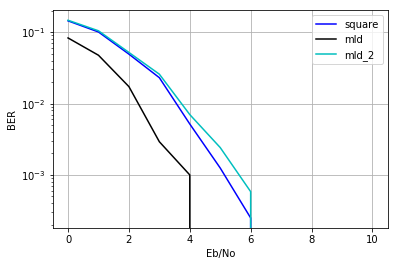

In [18]:
x = np.array(range(0, 11))

plt.semilogy(x,square_BER, label='square', color='b')
# plt.semilogy(x,exp_square_BER, label='exp_square', color='g')
plt.semilogy(x,mld_BER, label='mld', color='k')
plt.semilogy(x,mld_2_BER, label='mld_2', color='c')
# plt.semilogy(x,bpsk_BER, label='bpsk', color='k')


plt.xlabel('Eb/No')
plt.ylabel('BER')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.savetxt('square.txt',square_BER)
# np.savetxt('exp_square.txt',exp_square_BER)
np.savetxt('mld.txt', mld_BER)
